# Lecture 4 - Standard Errors

In [1]:
import numpy as np
import pandas as pd

import statsmodels
# we will use `smf` and `sm` to constract and estimate same regressions but using different ways
import statsmodels.formula.api as smf  
import statsmodels.api as sm
import statsmodels.stats.api as sms
from patsy import dmatrices

import seaborn as sns
sns.set(color_codes=True)

from matplotlib import pyplot as plt

## 1: Examine the Daily Closings of the Global Equity Index Data

The raw data consists of 2665 observations of daily closing values of the following representative equity indices spanning the trading dates 27-April-1993 to 14-July-2003:

- Canada: TSX Composite (Ticker ^GSPTSE)
- France: CAC 40        (Ticker ^FCHI)
- Germany: DAX           (Ticker ^GDAXI)
- Japan: Nikkei 225    (Ticker ^N225)
- UK: FTSE 100      (Ticker ^FTSE)
- US: S&P 500       (Ticker ^GSPC)

### 1a: Load data and reassign index as dates

In [14]:
df = pd.read_csv('data/Data_GlobalIdx1.csv')
df

,Dates,TSX,CAC,DAX,NIK,FTSE,SP
0,27-Apr-93,3691.2,1927.40,1640.80,20207.00,2832.70,438.01
1,28-Apr-93,3710.2,1942.50,1628.90,20455.00,2797.30,438.02
2,29-Apr-93,3755.0,1920.60,1623.90,20687.00,2786.80,438.89
3,30-Apr-93,3789.4,1939.00,1627.20,20919.00,2813.10,440.19
4,3-May-93,3773.4,1937.00,1629.20,20844.75,2812.85,442.46
...,...,...,...,...,...,...,...
2660,8-Jul-03,7089.6,3177.97,3344.46,9898.72,4073.60,1007.84
2661,9-Jul-03,7117.3,3139.93,3322.43,9990.95,4054.70,1002.21
2662,10-Jul-03,7071.5,3098.28,3269.84,9955.62,4028.80,988.70
2663,11-Jul-03,7077.6,3138.27,3326.51,9635.35,4058.10,998.14


#### Automatically create `datetime` index in DataFrame

In [15]:
dftry=df.copy()
dftry.index=pd.to_datetime(df['Dates'],errors='coerce')
dftry.drop(columns=['Dates'],inplace=True)
dftry

,TSX,CAC,DAX,NIK,FTSE,SP
Dates,,,,,,
1993-04-27,3691.2,1927.40,1640.80,20207.00,2832.70,438.01
1993-04-28,3710.2,1942.50,1628.90,20455.00,2797.30,438.02
1993-04-29,3755.0,1920.60,1623.90,20687.00,2786.80,438.89
1993-04-30,3789.4,1939.00,1627.20,20919.00,2813.10,440.19
1993-05-03,3773.4,1937.00,1629.20,20844.75,2812.85,442.46
...,...,...,...,...,...,...
2003-07-08,7089.6,3177.97,3344.46,9898.72,4073.60,1007.84
2003-07-09,7117.3,3139.93,3322.43,9990.95,4054.70,1002.21
2003-07-10,7071.5,3098.28,3269.84,9955.62,4028.80,988.70


Data snapshot:  
`Dates,TSX,CAC,DAX,NIK,FTSE,SP`  <br>
`27-Apr-93,3691.2,1927.4,1640.8,20207,2832.7,438.01`  <br>
`28-Apr-93,3710.2,1942.5,1628.9,20455,2797.3,438.02`  <br>
`29-Apr-93,3755,1920.6,1623.9,20687,2786.8,438.89`  <br>
`30-Apr-93,3789.4,1939,1627.2,20919,2813.1,440.19`<br>

The function `to_datetime(arg, errors)` converts a scalar, arrays, Series or DataFrame to a pandas datetime object.

Parameters (for full list of options, including dealing with time zones, see __[pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html)__:
> `arg` : `int`, `float`, `str`, `datetime`, `list`, `tuple`, `1-d array`, `Series`, `DataFrame`. If a `DataFrame` is provided, the method expects minimally the following columns: "year", "month", "day". <br>
> <br>
> `errors{‘ignore’, ‘raise’, ‘coerce’}`, default `‘raise’`<br>
> - If `'raise'`, then invalid parsing will **raise an exception**.<br>
> - If `'coerce'`, then invalid parsing will be **set as NaT**.<br>
> - If `'ignore'`, then invalid parsing will **return the input**.

If a date does not meet the timestamp limitations, passing `errors='ignore'` will return the original input instead of raising any exception.  

- %Y : Year with century as a decimal number (2010, 2011, ...).
- %y : Year without century as a zero-padded decimal number (10, 11).
- %b : Month as abbreviated name (Jan, Feb,...).
- %d : Day of the month as a zero-padded decimal number (01,02,...,31).

For date format options see __[this link](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)__.


In [16]:
df

,Dates,TSX,CAC,DAX,NIK,FTSE,SP
0,27-Apr-93,3691.2,1927.40,1640.80,20207.00,2832.70,438.01
1,28-Apr-93,3710.2,1942.50,1628.90,20455.00,2797.30,438.02
2,29-Apr-93,3755.0,1920.60,1623.90,20687.00,2786.80,438.89
3,30-Apr-93,3789.4,1939.00,1627.20,20919.00,2813.10,440.19
4,3-May-93,3773.4,1937.00,1629.20,20844.75,2812.85,442.46
...,...,...,...,...,...,...,...
2660,8-Jul-03,7089.6,3177.97,3344.46,9898.72,4073.60,1007.84
2661,9-Jul-03,7117.3,3139.93,3322.43,9990.95,4054.70,1002.21
2662,10-Jul-03,7071.5,3098.28,3269.84,9955.62,4028.80,988.70
2663,11-Jul-03,7077.6,3138.27,3326.51,9635.35,4058.10,998.14


In [17]:
pd.to_datetime(df['Dates'], format='%Y-%m-%d', errors='ignore')

0       27-Apr-93
1       28-Apr-93
2       29-Apr-93
3       30-Apr-93
4        3-May-93
          ...    
2660     8-Jul-03
2661     9-Jul-03
2662    10-Jul-03
2663    11-Jul-03
2664    14-Jul-03
Name: Dates, Length: 2665, dtype: object

Passing `errors='coerce'` will force an out-of-bounds date to `NaT`, in addition to forcing non-dates (or non-parseable dates) to `NaT`.

In [18]:
pd.to_datetime(df['Dates'], format='%Y-%m-%d', errors='coerce')

0      NaT
1      NaT
2      NaT
3      NaT
4      NaT
        ..
2660   NaT
2661   NaT
2662   NaT
2663   NaT
2664   NaT
Name: Dates, Length: 2665, dtype: datetime64[ns]

In [19]:
pd.to_datetime(df['Dates'], format='%d-%b-%y', errors='coerce')

0      1993-04-27
1      1993-04-28
2      1993-04-29
3      1993-04-30
4      1993-05-03
          ...    
2660   2003-07-08
2661   2003-07-09
2662   2003-07-10
2663   2003-07-11
2664   2003-07-14
Name: Dates, Length: 2665, dtype: datetime64[ns]

<div class="alert alert-block alert-success">
    <B>Hint:</B>
    Passing <CODE>infer_datetime_format=True</CODE> tells Python to 'guess' the format, if it is not in a regular format.
</div> 


In [20]:
%timeit pd.to_datetime(df['Dates'], infer_datetime_format=True) 

135 ms ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%timeit pd.to_datetime(df['Dates'], infer_datetime_format=False)

133 ms ± 2.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


As you can see from above, automating datetime format infernal takes only a few milliseconds longer.

In [22]:
df

,Dates,TSX,CAC,DAX,NIK,FTSE,SP
0,27-Apr-93,3691.2,1927.40,1640.80,20207.00,2832.70,438.01
1,28-Apr-93,3710.2,1942.50,1628.90,20455.00,2797.30,438.02
2,29-Apr-93,3755.0,1920.60,1623.90,20687.00,2786.80,438.89
3,30-Apr-93,3789.4,1939.00,1627.20,20919.00,2813.10,440.19
4,3-May-93,3773.4,1937.00,1629.20,20844.75,2812.85,442.46
...,...,...,...,...,...,...,...
2660,8-Jul-03,7089.6,3177.97,3344.46,9898.72,4073.60,1007.84
2661,9-Jul-03,7117.3,3139.93,3322.43,9990.95,4054.70,1002.21
2662,10-Jul-03,7071.5,3098.28,3269.84,9955.62,4028.80,988.70
2663,11-Jul-03,7077.6,3138.27,3326.51,9635.35,4058.10,998.14


In [23]:
df.index=pd.to_datetime(df['Dates'],format='%d-%b-%y', errors='coerce')
df.drop(columns=['Dates'],inplace=True)
df

,TSX,CAC,DAX,NIK,FTSE,SP
Dates,,,,,,
1993-04-27,3691.2,1927.40,1640.80,20207.00,2832.70,438.01
1993-04-28,3710.2,1942.50,1628.90,20455.00,2797.30,438.02
1993-04-29,3755.0,1920.60,1623.90,20687.00,2786.80,438.89
1993-04-30,3789.4,1939.00,1627.20,20919.00,2813.10,440.19
1993-05-03,3773.4,1937.00,1629.20,20844.75,2812.85,442.46
...,...,...,...,...,...,...
2003-07-08,7089.6,3177.97,3344.46,9898.72,4073.60,1007.84
2003-07-09,7117.3,3139.93,3322.43,9990.95,4054.70,1002.21
2003-07-10,7071.5,3098.28,3269.84,9955.62,4028.80,988.70


## 1b: Plot data

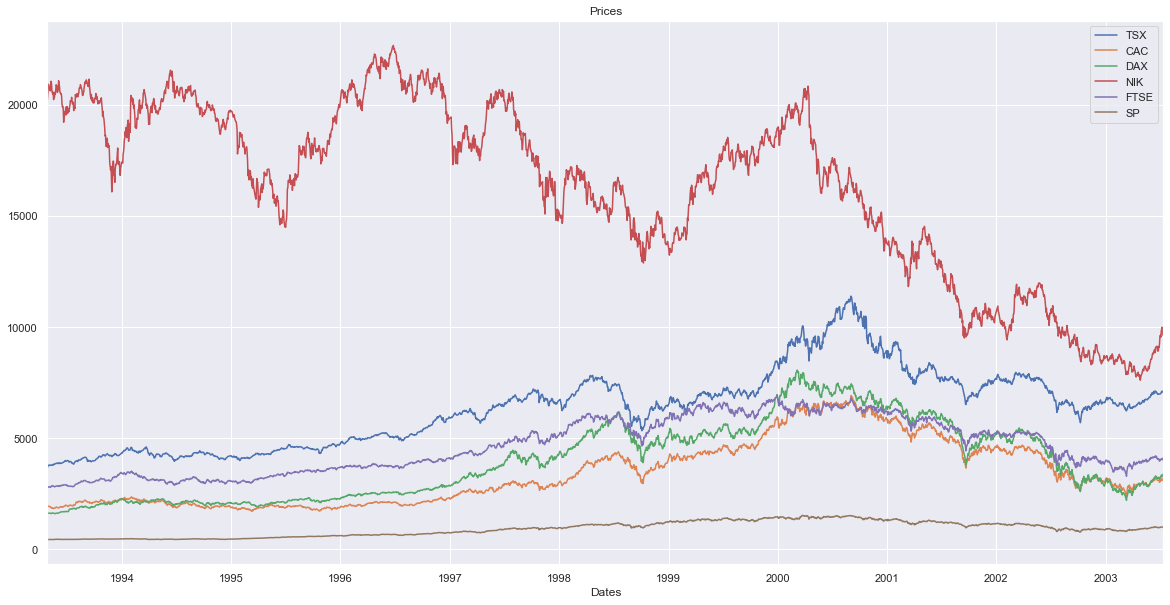

In [24]:
df.plot(title='Prices',figsize=(20,10));

In [25]:
ret = df.pct_change()
ret

,TSX,CAC,DAX,NIK,FTSE,SP
Dates,,,,,,
1993-04-27,NaN,NaN,NaN,NaN,NaN,NaN
1993-04-28,0.005147,0.007834,-0.007253,0.012273,-0.012497,0.000023
1993-04-29,0.012075,-0.011274,-0.003070,0.011342,-0.003754,0.001986
1993-04-30,0.009161,0.009580,0.002032,0.011215,0.009437,0.002962
1993-05-03,-0.004222,-0.001031,0.001229,-0.003549,-0.000089,0.005157
...,...,...,...,...,...,...
2003-07-08,0.002999,-0.001326,0.003477,0.010573,-0.000294,0.003405
2003-07-09,0.003907,-0.011970,-0.006587,0.009317,-0.004640,-0.005586
2003-07-10,-0.006435,-0.013265,-0.015829,-0.003536,-0.006388,-0.013480


In [26]:
ret.iloc[0,:]=np.zeros((1,ret.shape[1]))
ret

,TSX,CAC,DAX,NIK,FTSE,SP
Dates,,,,,,
1993-04-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1993-04-28,0.005147,0.007834,-0.007253,0.012273,-0.012497,0.000023
1993-04-29,0.012075,-0.011274,-0.003070,0.011342,-0.003754,0.001986
1993-04-30,0.009161,0.009580,0.002032,0.011215,0.009437,0.002962
1993-05-03,-0.004222,-0.001031,0.001229,-0.003549,-0.000089,0.005157
...,...,...,...,...,...,...
2003-07-08,0.002999,-0.001326,0.003477,0.010573,-0.000294,0.003405
2003-07-09,0.003907,-0.011970,-0.006587,0.009317,-0.004640,-0.005586
2003-07-10,-0.006435,-0.013265,-0.015829,-0.003536,-0.006388,-0.013480


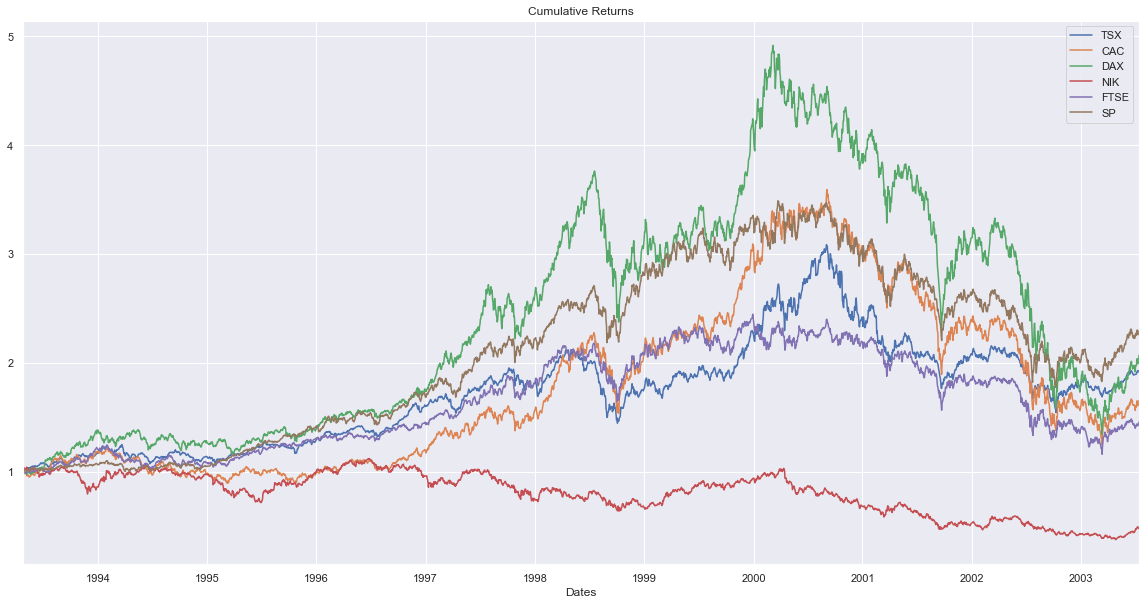

In [27]:
((1 + ret).cumprod()).plot(title='Cumulative Returns',figsize=(20,10));

### Logarithmic vs Arithmetic returns

Panda's `pct_change()` calculates percentage change, i.e. arithmetic return. If you want to use logarithmic return, you can easily conver it using the following formula assuming $R_t$ is arithmetic return on day $t$ and $r_t$ is logarithmic.

$r_t=\log{\left(1+R_t\right)}$  

Why?  
$r_t=\log{\left(1+R_t\right)}=\log{\left(1+\frac{P_{t}-P_{t-1}}{P_{t-1}}\right)}=\log{\left(1+\frac{P_{t}}{P_{t-1}}-1\right)}=\log{\left(\frac{P_{t}}{P_{t-1}}\right)}$  



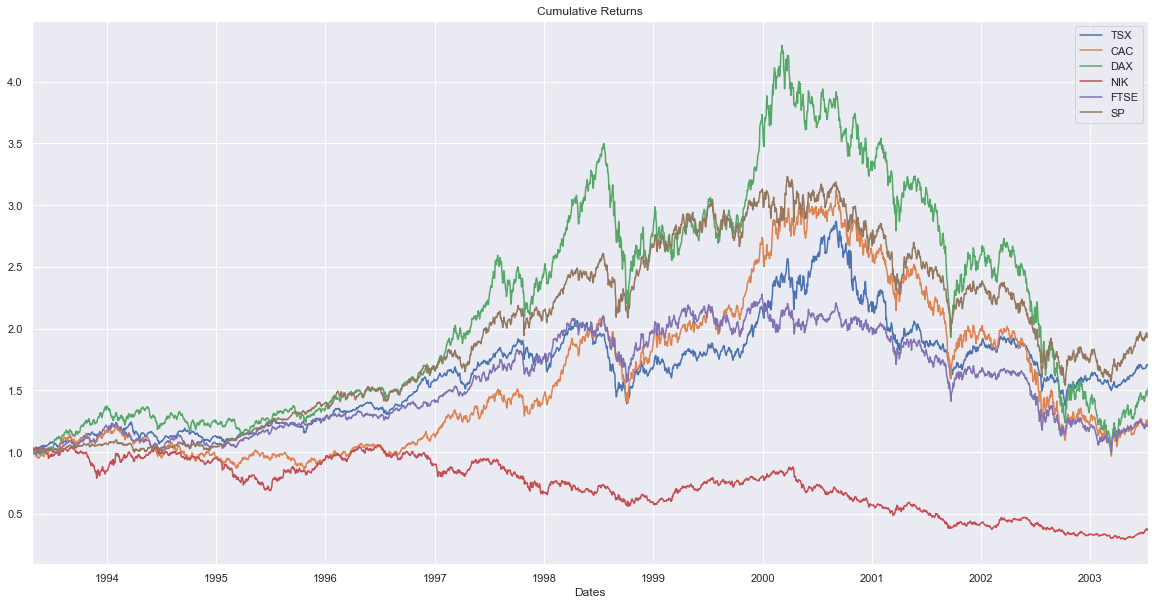

In [28]:
((1 + np.log(1+ret)).cumprod()).plot(title='Cumulative Returns',figsize=(20,10)); # note the y-scale and contrast the two graphs

## 1c : Get portfolio returns and plot it

In preparation for subsequent modeling, specify the portfolio weight vector. Although an equally weighted portfolio is assumed, you can change the weight vector to examine any other portfolio composition or even a single country. Note that the portfolio weights are fixed throughout the horizon, and that the simulation ignores any transaction costs required to rebalance the portfolio (the daily rebalancing process is assumed to be self-financing).

In [29]:
# Get equally weighted portfolio weights:
nIndices=df.shape[1]                               # number of indices
weights = np.tile(1/nIndices,(1,nIndices))         # weights in equally weighted portfolio
print(weights)
weights.shape

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]]


(1, 6)

In [30]:
ret

,TSX,CAC,DAX,NIK,FTSE,SP
Dates,,,,,,
1993-04-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1993-04-28,0.005147,0.007834,-0.007253,0.012273,-0.012497,0.000023
1993-04-29,0.012075,-0.011274,-0.003070,0.011342,-0.003754,0.001986
1993-04-30,0.009161,0.009580,0.002032,0.011215,0.009437,0.002962
1993-05-03,-0.004222,-0.001031,0.001229,-0.003549,-0.000089,0.005157
...,...,...,...,...,...,...
2003-07-08,0.002999,-0.001326,0.003477,0.010573,-0.000294,0.003405
2003-07-09,0.003907,-0.011970,-0.006587,0.009317,-0.004640,-0.005586
2003-07-10,-0.006435,-0.013265,-0.015829,-0.003536,-0.006388,-0.013480


In [31]:
logret=np.log(1+ret)
logret

,TSX,CAC,DAX,NIK,FTSE,SP
Dates,,,,,,
1993-04-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1993-04-28,0.005134,0.007804,-0.007279,0.012198,-0.012576,0.000023
1993-04-29,0.012003,-0.011338,-0.003074,0.011278,-0.003761,0.001984
1993-04-30,0.009119,0.009535,0.002030,0.011152,0.009393,0.002958
1993-05-03,-0.004231,-0.001032,0.001228,-0.003556,-0.000089,0.005144
...,...,...,...,...,...,...
2003-07-08,0.002995,-0.001327,0.003471,0.010517,-0.000295,0.003399
2003-07-09,0.003900,-0.012042,-0.006609,0.009274,-0.004650,-0.005602
2003-07-10,-0.006456,-0.013353,-0.015955,-0.003542,-0.006408,-0.013572


In [32]:
port=logret.multiply(weights, axis=1).sum(axis=1)
port

Dates
1993-04-27    0.000000
1993-04-28    0.000884
1993-04-29    0.001182
1993-04-30    0.007365
1993-05-03   -0.000423
                ...   
2003-07-08    0.003127
2003-07-09   -0.002622
2003-07-10   -0.009881
2003-07-11    0.002487
2003-07-14    0.012938
Length: 2665, dtype: float64

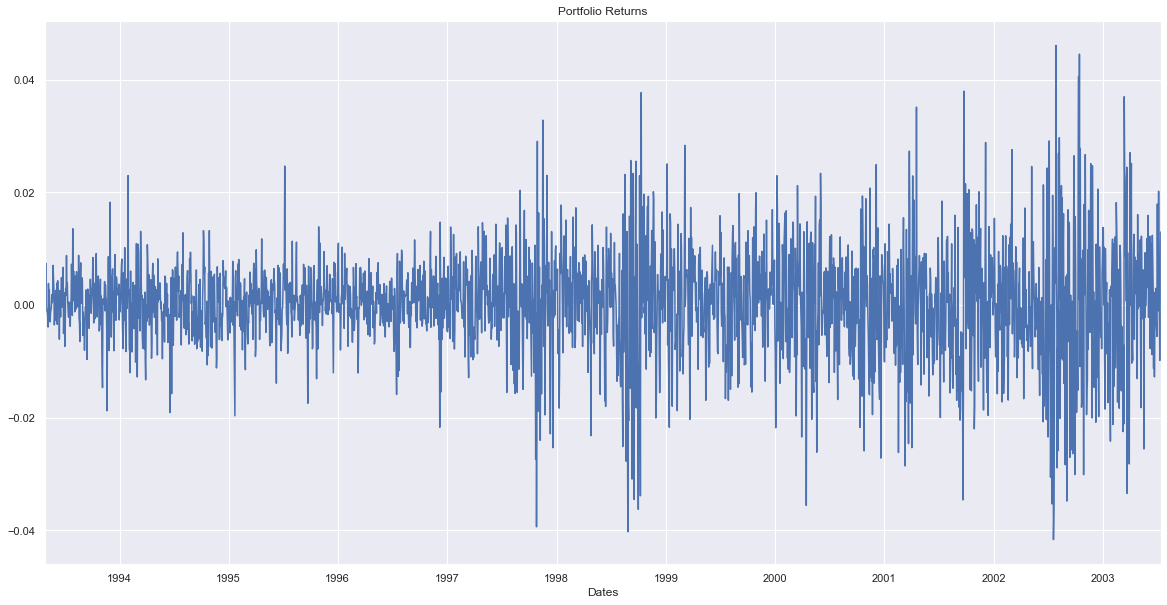

In [34]:
port.plot(title='Portfolio Returns',figsize=(20,10));

## 1d: Analyse returns

Most financial return series exhibit some degree of autocorrelation and, more importantly, heteroskedasticity. How to get series to be approximately independent and identically distributed?  

For example, the sample autocorrelation function (ACF) of the portfolio returns reveal some mild serial correlation.

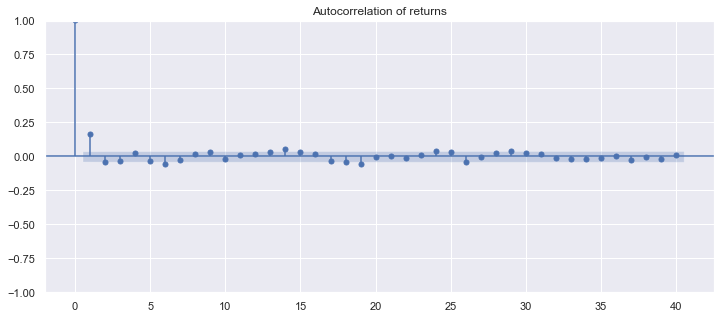

In [35]:
fig, ax = plt.subplots(figsize=(12,5))
sm.graphics.tsa.plot_acf(port.values, 
                         lags=40, alpha=0.05, adjusted=False, zero=True,
                         title="Autocorrelation of returns",
                         ax=ax)
plt.show()

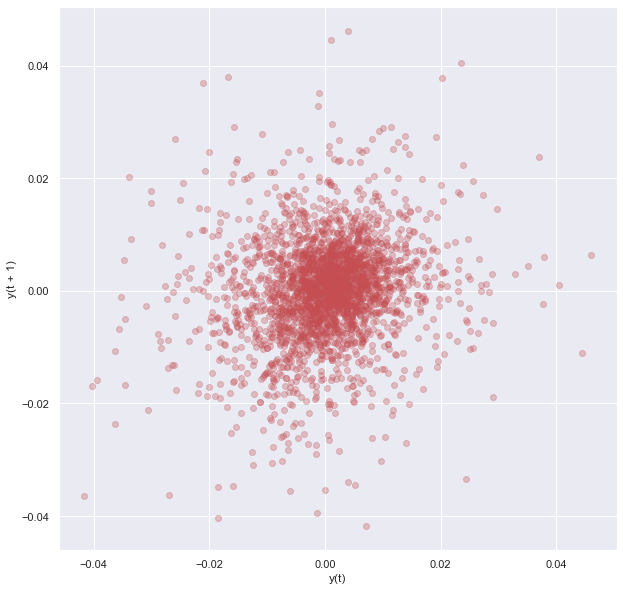

In [36]:
# from pandas.plotting import lag_plot
fig, ax = plt.subplots(figsize=(10,10))
pd.plotting.lag_plot(port,lag=1,c='r', alpha=0.3);

### Create your own `lag_plot` function

In [64]:
# Create a series of shifted (lagged) variables:

# Create a stack of series shifted by 0, 1, 2, 3 periods and combine them to a single DataFrame:
P=pd.concat([port, port.shift(), port.shift(2), port.shift(3)], axis=1).dropna()          # .dropna()  #adding this will remove rows that contain NaN at the top of the new table when variables were shifted

# Change column names to make it more understandible what each column represents:
P.columns=['t-{}'.format(i) for i in range(P.shape[1])]
P.rename(columns = {'t-0':'t'},inplace=True)

In [65]:
P

,t,t-1,t-2,t-3
Dates,,,,
1993-04-30,0.007365,0.001182,0.000884,0.000000
1993-05-03,-0.000423,0.007365,0.001182,0.000884
1993-05-04,-0.001101,-0.000423,0.007365,0.001182
1993-05-05,-0.001147,-0.001101,-0.000423,0.007365
1993-05-06,-0.001914,-0.001147,-0.001101,-0.000423
...,...,...,...,...
2003-07-08,0.003127,0.020176,-0.001035,0.000927
2003-07-09,-0.002622,0.003127,0.020176,-0.001035
2003-07-10,-0.009881,-0.002622,0.003127,0.020176


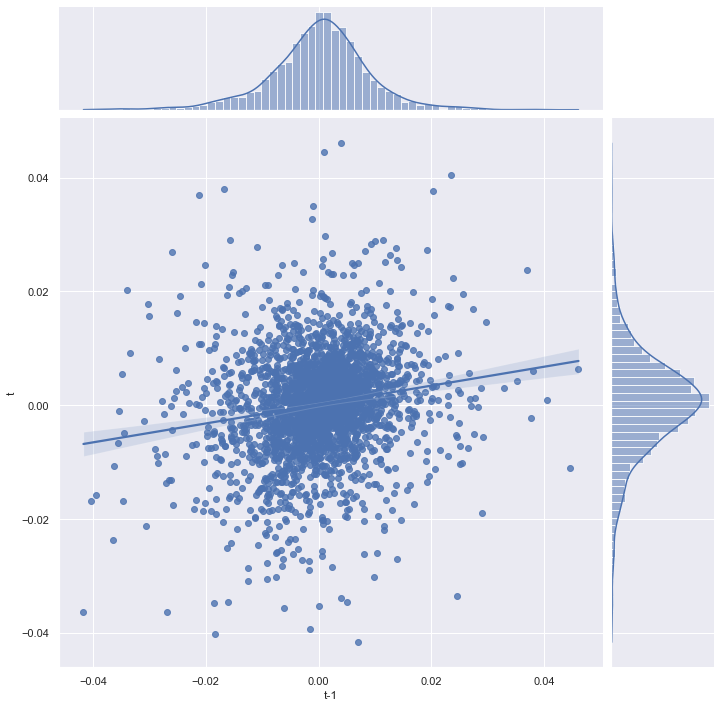

In [66]:
sns.jointplot(x="t-1", y="t", data=P,
           kind="reg", height=10, space=0.08);

You can create a time-lagged version of the data set by using the `shift(n)` operator on Pandas class where `n` is the number of lags. Doing so, you can get additional statistics and be able to customize your plots with meaningful information:

In [67]:
# Load SciPy's correlation function
from scipy.stats import pearsonr

# Define number of lags
lags=0; # TRY lags=1, or others

# Find correlation (and ignore other optional output by stating '_')
# Note that in order to find correlation, we start each original and shifted series from a position at `lag`
# because when series are shifted, missing values are created to keep the length of series same as original
corr, _ = pearsonr(port.values[lags:], port.shift(lags).values[lags:])
corr

0.9999999999999999

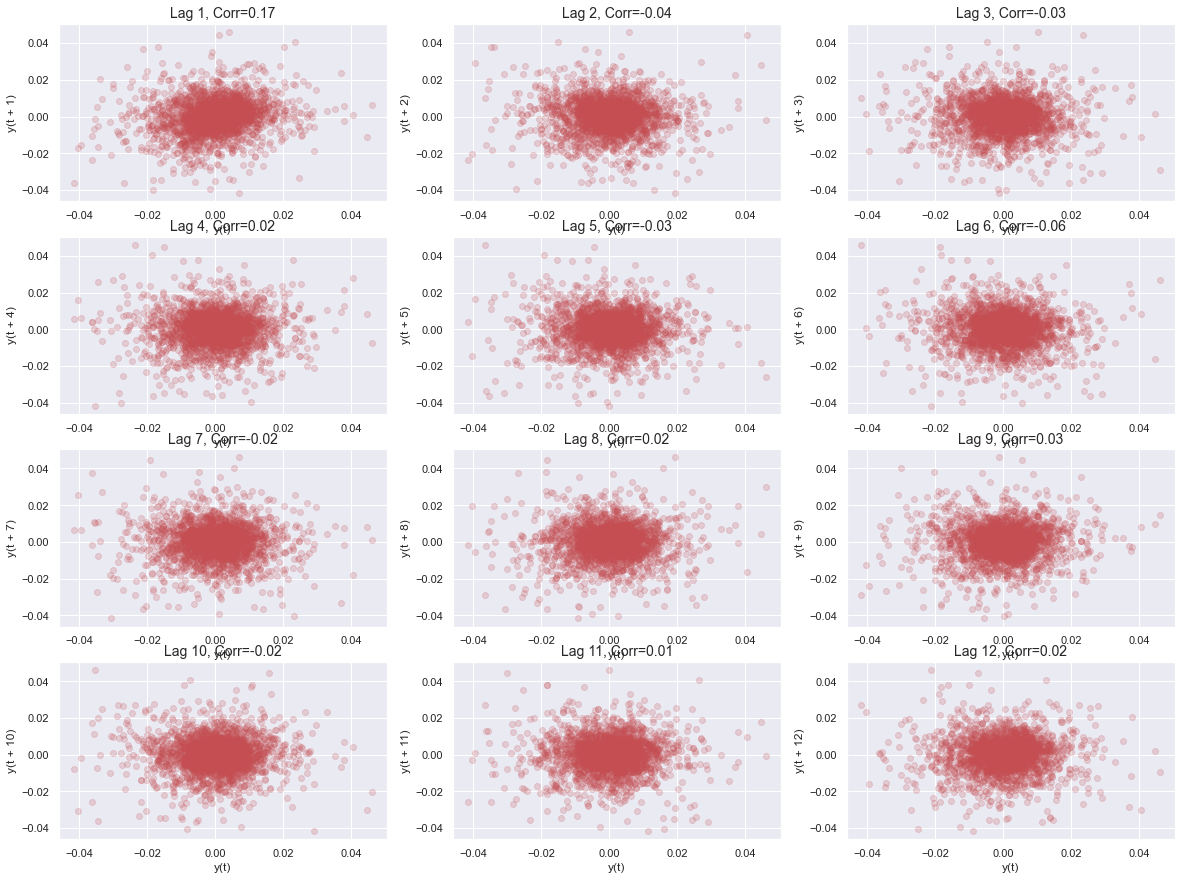

In [70]:
fig = plt.subplots(figsize=(20,15))

NumberOfLags=12

for i in range(1, NumberOfLags+1):
    ax = plt.subplot(4, 3, i)
    ax.set_title('Lag ' + str(i) + ', Corr=' + "{:.2f}".format(pearsonr(port.values[i:], port.shift(i).values[i:])[0]), 
                 fontdict={'fontsize': 14})
    ax=pd.plotting.lag_plot(port,lag=i,c='r', alpha=0.2);
    
plt.show()

However, the sample ACF of the **squared returns** illustrates the degree of persistence in variance and implies that GARCH modeling may be required.

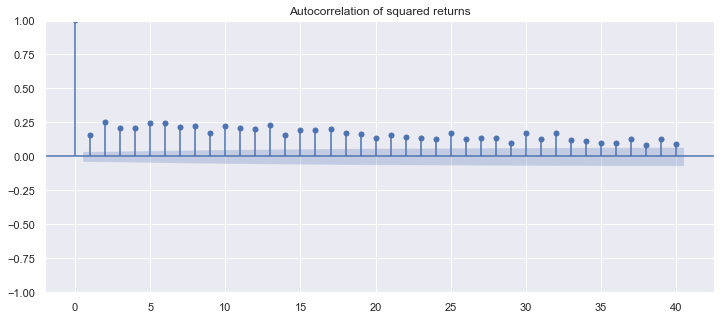

In [71]:
fig, ax = plt.subplots(figsize=(12,5))
sm.graphics.tsa.plot_acf(port.values**2, 
                         lags=40, alpha=0.05, adjusted=False, zero=True,
                         title="Autocorrelation of squared returns",
                         ax=ax)
plt.show()

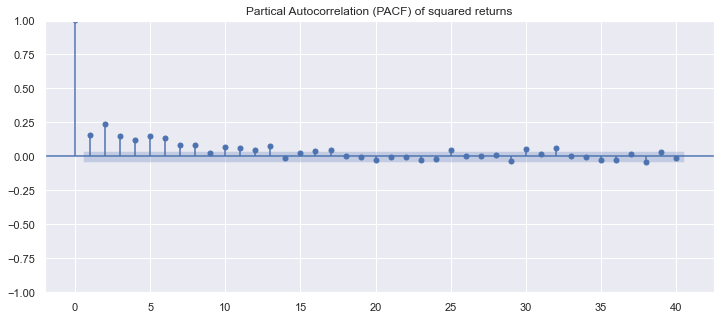

In [73]:
fig, ax = plt.subplots(figsize=(12,5))
sm.graphics.tsa.plot_pacf(port.values**2, 
                         lags=40, alpha=0.05, method='ywm',
                         title="Partical Autocorrelation (PACF) of squared returns",
                         ax=ax)
plt.show()

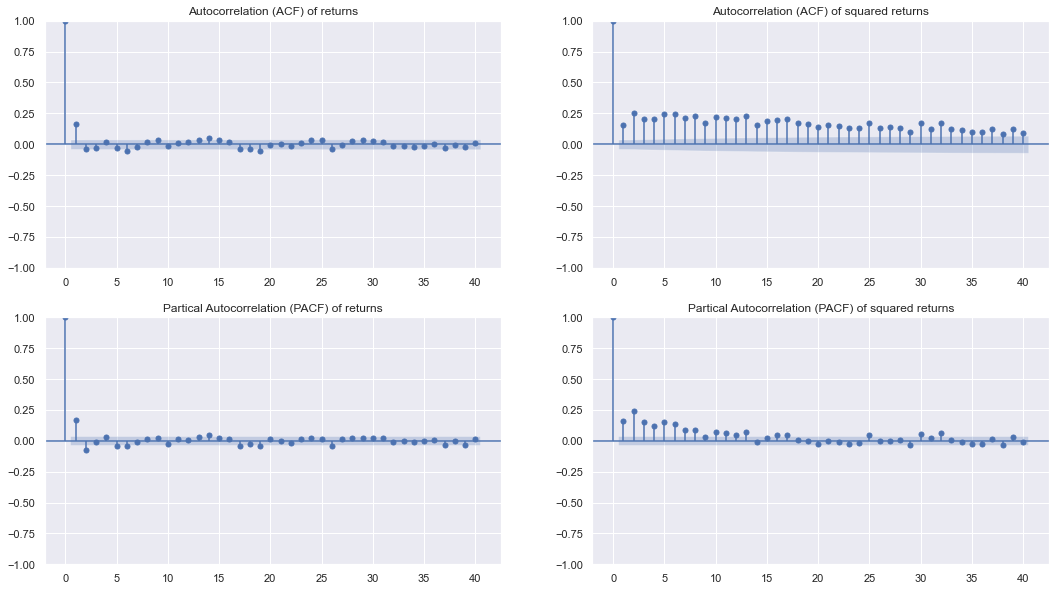

In [75]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,10))
sm.graphics.tsa.plot_acf(port.values, 
                         lags=40, alpha=0.05,  
                         title="Autocorrelation (ACF) of returns",
                         ax=ax[0,0])
sm.graphics.tsa.plot_pacf(port.values, 
                         lags=40, alpha=0.05,  method='ywm',
                         title="Partical Autocorrelation (PACF) of returns",
                         ax=ax[1,0])
sm.graphics.tsa.plot_acf(port.values**2, 
                         lags=40, alpha=0.05,  
                         title="Autocorrelation (ACF) of squared returns",
                         ax=ax[0,1])
sm.graphics.tsa.plot_pacf(port.values**2, 
                         lags=40, alpha=0.05,  method='ywm',
                         title="Partical Autocorrelation (PACF) of squared returns",
                         ax=ax[1,1])
plt.show()

## 1e: Test for Heteroscedasticity

### Breusch-Pagan test
Python example in previous sessions.

[Breusch-Pagan test](https://en.wikipedia.org/wiki/Breusch%E2%80%93Pagan_test)

### Engle test for residual heteroscedasticity

Engle's ARCH test assesses the null hypothesis that a series of residuals ($\epsilon_t$) exhibits no conditional heteroscedasticity (ARCH effects), against the alternative that an ARCH($L$) model describes the series. The ARCH($L$) model has the following form:  

$\epsilon_t^2=a_0+a_1\epsilon_{t-1}^2+\dots+a_L\epsilon_{t-L}^2+e_t$,   

where there is at least one $a_j \ne 0$, $j = 0,\dots,L$.

The test statistic is the Lagrange multiplier statistic $TR^2$, where:  
- $T$ is the sample size.
- $R^2$ is the coefficient of determination from fitting the ARCH($L$) model for a number of lags ($L$) via regression.

Under the null hypothesis, the asymptotic distribution of the test statistic is chi-square with $L$ degrees of freedom.

In [76]:
res=port-np.mean(port)
res

Dates
1993-04-27   -0.000148
1993-04-28    0.000736
1993-04-29    0.001034
1993-04-30    0.007217
1993-05-03   -0.000571
                ...   
2003-07-08    0.002979
2003-07-09   -0.002770
2003-07-10   -0.010029
2003-07-11    0.002339
2003-07-14    0.012790
Length: 2665, dtype: float64

In [77]:
LM,LMpvalue,F,Fpvalue=statsmodels.stats.diagnostic.het_arch(res,nlags=1)
LMpvalue

# fstatistic for F test is an alternative version of the LM test but based on F test for the parameter restriction

1.4261243995628325e-16

## 2: Population Survey example

In [79]:
df = pd.read_csv('data/cps12.csv')
df

,year,ahe,bachelor,female,age
0,2012,19.230770,0,0,30
1,2012,17.548077,0,0,29
2,2012,8.547009,0,0,27
3,2012,16.826923,0,1,25
4,2012,16.346153,1,1,27
...,...,...,...,...,...
7435,2012,14.423077,0,0,25
7436,2012,7.692307,0,0,32
7437,2012,11.538462,0,0,30
7438,2012,9.134615,0,1,25


Run a regression of average hourly earnings ($ahe$) on age ($age$), gender ($female$), and education ($bachelor$).  

What is the estimated effect of Age on earnings? 

In [80]:
ols = smf.ols('ahe ~ age + bachelor + female', data=df)
reg=ols.fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ahe   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     544.5
Date:                Sat, 26 Feb 2022   Prob (F-statistic):          6.51e-320
Time:                        14:47:29   Log-Likelihood:                -27443.
No. Observations:                7440   AIC:                         5.489e+04
Df Residuals:                    7436   BIC:                         5.492e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8662      1.188      1.571      0.116      -0.462       4.194
age            0.5103      0.040     12.912      0.000       0.433       0.588
bachelor       8.3186      0.227     36.584      0.000       7.873       8.764
female        -3.8103      0.230    -16.596      0.000      -4.260      -3.360
==============================================================================
Omnibus:                     1975.582   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6089.399
Skew:                           1.360   Prob(JB):                         0.00
Kurtosis:                       6.499   Cond. No.                         316.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

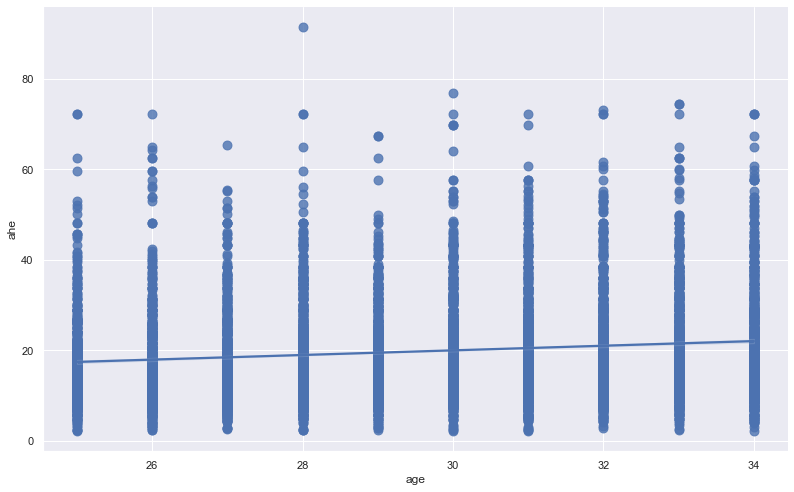

In [81]:
sns.lmplot(x="age", y="ahe", data=df, 
           scatter_kws={"s": 80}, 
           height=7, aspect=1.6);

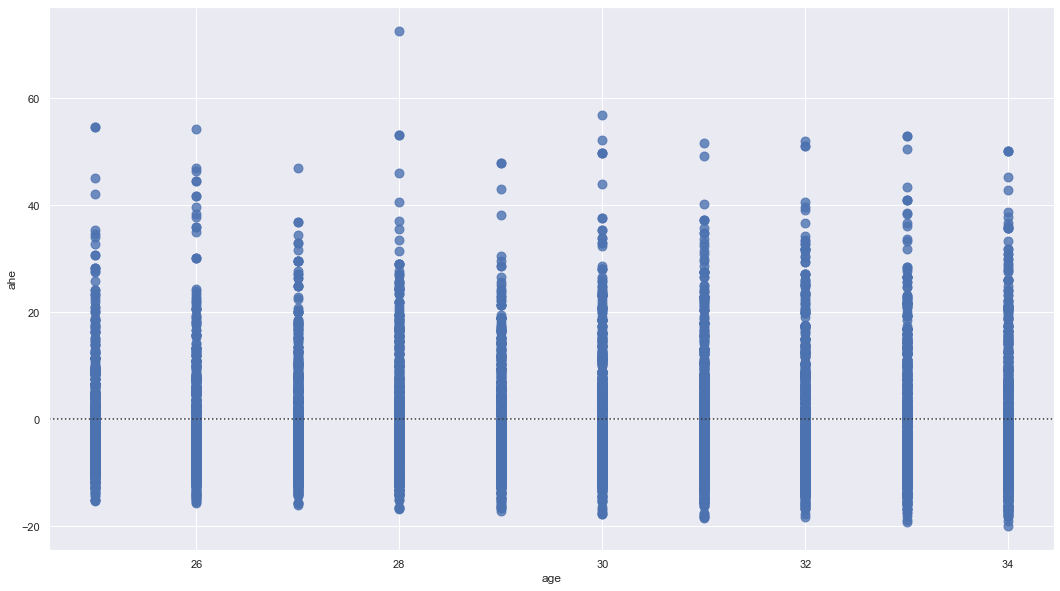

In [82]:
fig, ax = plt.subplots(figsize=(18,10))
sns.residplot(x="age", y="ahe", data=df,
              scatter_kws={"s": 80});

Text(0, 0.5, 'Residuals')

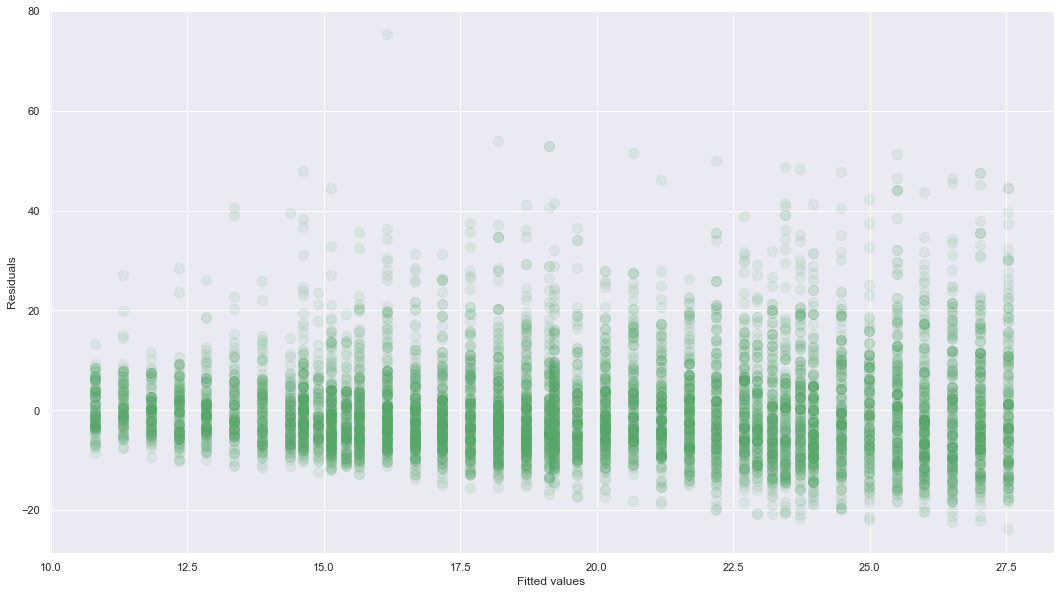

In [83]:
fig, ax = plt.subplots(figsize=(18,10))
ax.plot(reg.fittedvalues, reg.resid, 
        marker='o', markersize=10, color='g', alpha=0.1,
       linestyle='')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

### Calculate the Durbin-Watson statistic

The null hypothesis of the test is that there is no serial correlation. If $\epsilon_t$ is the residual given by $\epsilon_t = \rho \epsilon_{t−1} + \nu_t$, Durbin -Watson statistic states that null hypothesis: $\rho=0$, alternative hypothesis $\rho \neq 0$, then the Durbin-Watson test statistics is defined as:  

$$dw=\frac{\sum_{t=2}^{T}\left(\epsilon_t-\epsilon_{t-1}\right)^2}{\sum_{t=2}^{T}\left(\epsilon_t^2\right)}$$

The test statistic is approximately equal to $2*(1-\hat{\rho})$ where $\hat{\rho}$ is the sample autocorrelation of the residuals. Thus, for $\hat{\rho}=0$, indicating no serial correlation, the test statistic equals 2. This statistic will always be between 0 and 4. The closer to 0 the statistic, the more evidence for positive serial correlation. The closer to 4, the more evidence for negative serial correlation.

In [84]:
statsmodels.stats.stattools.durbin_watson(reg.resid)
# statsmodels.stats.diagnostic.acorr_ljungbox(x,lags=?) # for time series data

1.935294885489778

## HAC Standard errors and HAC estimator

Heteroscedasticity and autocorrelation consistent (HAC) errors.  

The error terms in a regression may be serially correlated due to serially correlated determinants of $Y_t$
that are not included as regressors. When these factors are not correlated with the regressors included in the model, serially correlated errors do not violate the assumption of exogeneity such that the OLS estimator remains unbiased and consistent.  

However, autocorrelated standard errors render the usual homoskedasticity-only and heteroskedasticity-robust standard errors invalid and may cause misleading inference. HAC errors are a remedy.

In [85]:
reg=ols.fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ahe   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     544.5
Date:                Sat, 26 Feb 2022   Prob (F-statistic):          6.51e-320
Time:                        14:48:54   Log-Likelihood:                -27443.
No. Observations:                7440   AIC:                         5.489e+04
Df Residuals:                    7436   BIC:                         5.492e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8662      1.188      1.571      0.116      -0.462       4.194
age            0.5103      0.040     12.912      0.000       0.433       0.588
bachelor       8.3186      0.227     36.584      0.000       7.873       8.764
female        -3.8103      0.230    -16.596      0.000      -4.260      -3.360
==============================================================================
Omnibus:                     1975.582   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6089.399
Skew:                           1.360   Prob(JB):                         0.00
Kurtosis:                       6.499   Cond. No.                         316.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [86]:
reg2=ols.fit(cov_type='HAC',cov_kwds={'maxlags':1})
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ahe   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     528.5
Date:                Sat, 26 Feb 2022   Prob (F-statistic):          2.38e-311
Time:                        14:49:23   Log-Likelihood:                -27443.
No. Observations:                7440   AIC:                         5.489e+04
Df Residuals:                    7436   BIC:                         5.492e+04
Df Model:                           3                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8662      1.186      1.573      0.116      -0.459       4.191
age            0.5103      0.040     12.793      0.000       0.432       0.588
bachelor       8.3186      0.227     36.609      0.000       7.873       8.764
female        -3.8103      0.222    -17.153      0.000      -4.246      -3.375
==============================================================================
Omnibus:                     1975.582   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6089.399
Skew:                           1.360   Prob(JB):                         0.00
Kurtosis:                       6.499   Cond. No.                         316.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [87]:
# Or you can use the get_robustcov_results method after fitting the model:
reg.get_robustcov_results(cov_type='HAC',maxlags=1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ahe   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     528.5
Date:                Sat, 26 Feb 2022   Prob (F-statistic):          2.38e-311
Time:                        14:49:54   Log-Likelihood:                -27443.
No. Observations:                7440   AIC:                         5.489e+04
Df Residuals:                    7436   BIC:                         5.492e+04
Df Model:                           3                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8662      1.186      1.573      0.116      -0.459       4.192
age            0.5103      0.040     12.793      0.000       0.432       0.588
bachelor       8.3186      0.227     36.609      0.000       7.873       8.764
female        -3.8103      0.222    -17.153      0.000      -4.246      -3.375
==============================================================================
Omnibus:                     1975.582   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6089.399
Skew:                           1.360   Prob(JB):                         0.00
Kurtosis:                       6.499   Cond. No.                         316.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

> Note: Can also use `use_t=True`. The `use_t` parameter tells `statsmodels` to use $t$-statistics to compute the $p$-values. You will not notice much difference in regression estimates for large sample sizes, but you should use it when your sample size is small.

## Clustered standard errors

In [88]:
df = pd.read_csv('data/panelData.csv')
df.head()

,Growth,City,Year,Employ
0,354.023699,1,1,64.187297
1,352.051710,1,2,65.093734
2,207.100961,1,3,55.520502
3,328.168176,1,4,63.594054
4,251.530908,1,5,63.101960


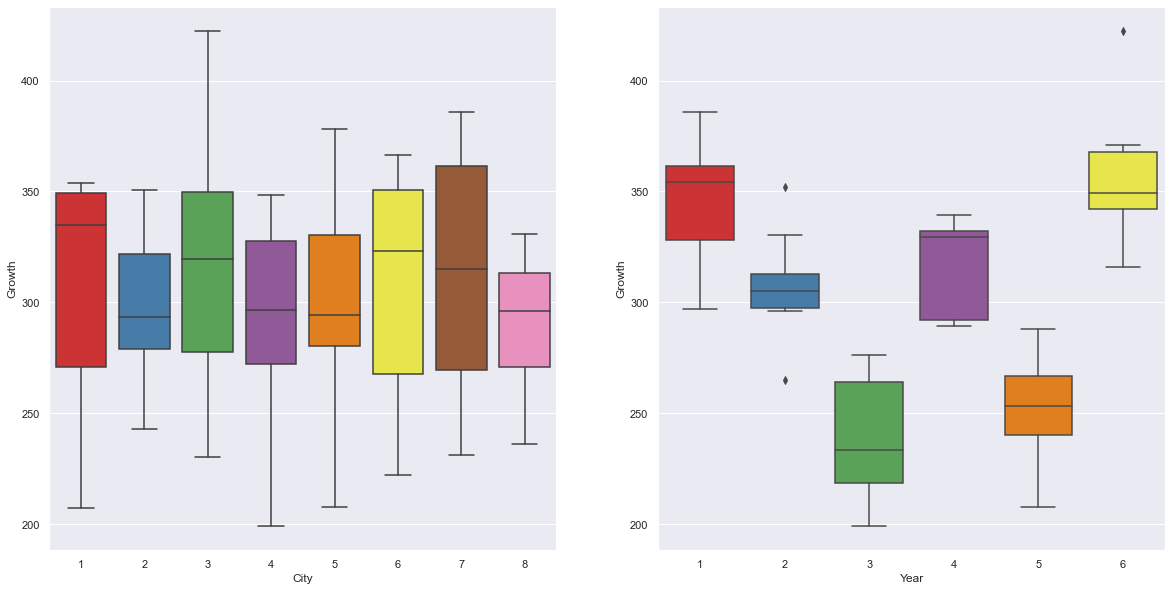

In [89]:
fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
sns.boxplot(x="City", y="Growth", data=df, palette="Set1", ax=ax1[0])
sns.boxplot(x="Year", y="Growth", data=df, palette="Set1", ax=ax1[1])
plt.show()

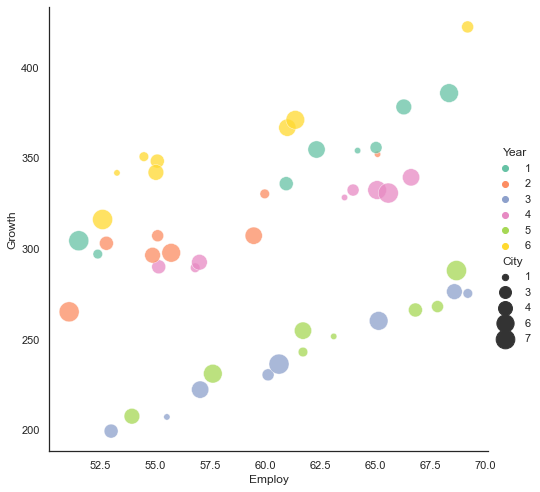

In [92]:
sns.set_theme(style="white")
sns.relplot(x="Employ", y="Growth", hue="Year", size="City",
            sizes=(40, 400), alpha=.75, palette="Set2",
            height=7, data=df);
#sns.regplot(x="Employ", y="Growth", data=df, scatter=False) # add a regression line to the plot

In [93]:
ols = smf.ols('Growth ~ Employ', data=df)
reg=ols.fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Growth   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     4.236
Date:                Sat, 26 Feb 2022   Prob (F-statistic):             0.0453
Time:                        14:57:21   Log-Likelihood:                -255.11
No. Observations:                  48   AIC:                             514.2
Df Residuals:                      46   BIC:                             518.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    139.4362     79.692      1.750      0.087     -20.975     299.847
Employ         2.7114      1.317      2.058      0.045       0.059       5.363
==============================================================================
Omnibus:                       11.092   Durbin-Watson:                   2.403
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                3.261
Skew:                          -0.234   Prob(JB):                        0.196
Kurtosis:                       1.812   Cond. No.                         665.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Residuals')

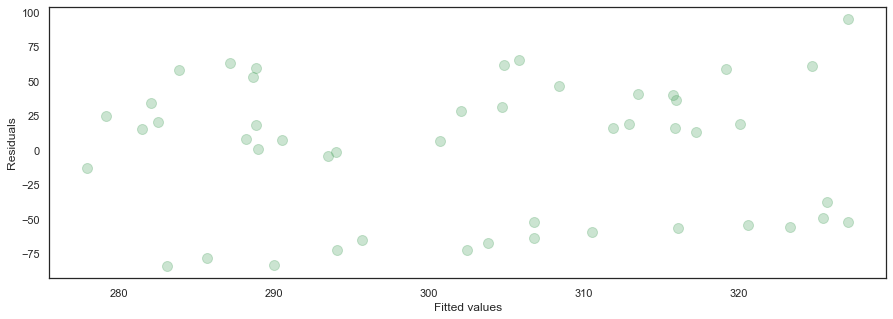

In [94]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(reg.fittedvalues, reg.resid, 
        marker='o', markersize=10, color='g', alpha=0.3,
       linestyle='')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

OLS Coefficients and Standard Errors Clustered by groups (e.g., categories)

Clustering can be achieved by passing cluster variable to the `cov_type` parameter. You also need to give an additional parameter `cov_kwds`, which indicates which group to cluster on. The parameters takes an arrays of labels, which can be the columns of a pandas `DataFrame` as in the current example (`City` or `Year`).

In [95]:
reg=ols.fit(cov_type='cluster', cov_kwds={'groups': df['City']})
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Growth   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     5.596
Date:                Sat, 26 Feb 2022   Prob (F-statistic):             0.0499
Time:                        14:58:36   Log-Likelihood:                -255.11
No. Observations:                  48   AIC:                             514.2
Df Residuals:                      46   BIC:                             518.0
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    139.4362     67.675      2.060      0.039       6.795     272.078
Employ         2.7114      1.146      2.366      0.018       0.465       4.958
==============================================================================
Omnibus:                       11.092   Durbin-Watson:                   2.403
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                3.261
Skew:                          -0.234   Prob(JB):                        0.196
Kurtosis:                       1.812   Cond. No.                         665.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [96]:
reg=ols.fit(cov_type='cluster', cov_kwds={'groups': df['Year']})
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Growth   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     5.913
Date:                Sat, 26 Feb 2022   Prob (F-statistic):             0.0593
Time:                        14:58:41   Log-Likelihood:                -255.11
No. Observations:                  48   AIC:                             514.2
Df Residuals:                      46   BIC:                             518.0
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    139.4362     65.030      2.144      0.032      11.980     266.892
Employ         2.7114      1.115      2.432      0.015       0.526       4.897
==============================================================================
Omnibus:                       11.092   Durbin-Watson:                   2.403
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                3.261
Skew:                          -0.234   Prob(JB):                        0.196
Kurtosis:                       1.812   Cond. No.                         665.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [97]:
reg=ols.fit(cov_type='cluster', cov_kwds={'groups': df[['City','Year']]}, use_t=False)
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Growth   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     9.669
Date:                Sat, 26 Feb 2022   Prob (F-statistic):             0.0266
Time:                        14:59:01   Log-Likelihood:                -255.11
No. Observations:                  48   AIC:                             514.2
Df Residuals:                      46   BIC:                             518.0
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    139.4362     48.331      2.885      0.004      44.709     234.163
Employ         2.7114      0.872      3.109      0.002       1.002       4.420
==============================================================================
Omnibus:                       11.092   Durbin-Watson:                   2.403
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                3.261
Skew:                          -0.234   Prob(JB):                        0.196
Kurtosis:                       1.812   Cond. No.                         665.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [98]:
reg=ols.fit(cov_type='nw-groupsum', 
            cov_kwds={'time': np.array(df['Year']), 'groups': np.array(df['City']), 'maxlags': 5}, 
            use_t=False)
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Growth   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     7.240
Date:                Sat, 26 Feb 2022   Prob (F-statistic):             0.0311
Time:                        14:59:14   Log-Likelihood:                -255.11
No. Observations:                  48   AIC:                             514.2
Df Residuals:                      46   BIC:                             518.0
Df Model:                           1                                         
Covariance Type:         hac-groupsum                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    139.4362     59.978      2.325      0.020      21.881     256.991
Employ         2.7114      1.008      2.691      0.007       0.736       4.686
==============================================================================
Omnibus:                       11.092   Durbin-Watson:                   2.403
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                3.261
Skew:                          -0.234   Prob(JB):                        0.196
Kurtosis:                       1.812   Cond. No.                         665.
==============================================================================

Notes:
[1] Driscoll and Kraay Standard Errors are robust to cluster correlation (HAC-Groupsum)
"""

### Adding dummy variables manually

One way to add fixed effects (clustering by groups or time) is by adding the corresponding dummy variables. Thankfully this is quite easy to do within a formula by using `C(var)` where `var` is the label variable. Note that this will work with a few entities/dates, but this will become numerically unstable if there is a large number of entities/dates. Plus, the large number of dummy variables make it unpleasant to look at.

also note the degrees of freedom `df` in the regression output. 

In [99]:
ols = smf.ols('Growth ~ Employ + C(Year) + C(City)', data=df)
reg=ols.fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Growth   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     167.3
Date:                Sat, 26 Feb 2022   Prob (F-statistic):           7.39e-27
Time:                        14:59:31   Log-Likelihood:                -157.06
No. Observations:                  48   AIC:                             342.1
Df Residuals:                      34   BIC:                             368.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       41.6622     15.068      2.765      0.009      11.040      72.285
C(Year)[T.2]   -15.4799      3.942     -3.927      0.000     -23.491      -7.469
C(Year)[T.3]  -106.1975      3.790    -28.018      0.000    -113.900     -98.495
C(Year)[T.4]   -30.5971      3.791     -8.071      0.000     -38.301     -22.893
C(Year)[T.5]  -100.8810      3.802    -26.533      0.000    -108.608     -93.154
C(Year)[T.6]    29.6604      3.885      7.635      0.000      21.766      37.555
C(City)[T.2]     0.2275      4.394      0.052      0.959      -8.703       9.158
C(City)[T.3]    -0.1222      4.424     -0.028      0.978      -9.112       8.868
C(City)[T.4]     1.9492      4.453      0.438      0.664      -7.100      10.998
C(City)[T.5]     0.4704      4.391      0.107      0.915      -8.452       9.393
C(City)[T.6]    -1.1442      4.378     -0.261      0.795     -10.042       7.753
C(City)[T.7]     0.1602      4.389      0.037      0.971      -8.759       9.079
C(City)[T.8]    -3.6281      4.414     -0.822      0.417     -12.598       5.342
Employ           4.9572      0.235     21.110      0.000       4.480       5.434
==============================================================================
Omnibus:                        1.635   Durbin-Watson:                   3.299
Prob(Omnibus):                  0.442   Jarque-Bera (JB):                1.128
Skew:                          -0.005   Prob(JB):                        0.569
Kurtosis:                       2.249   Cond. No.                         856.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Recall:

`ahe` = average hourly earnings (aka wages)
`age` in years, `bachelor`=1 if has higher education, `female`=1 if female.

In [102]:
df.Year.unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

In [103]:
df.City.unique()

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

> <font color=DeepPink>Exercise</font>: <br>
> Why there are some dummy variables missing in the regression output? E.g., City(1) and Year(1)?

In [104]:
df = pd.read_csv('data/cps12.csv')
ols = smf.ols('ahe ~ age', data=df)
# ols = smf.ols('ahe ~ age + bachelor + female', data=df)
ols = smf.ols('ahe ~ age + bachelor*female', data=df)
#ols = smf.ols('ahe ~ age + age*female + bachelor*female', data=df)
#ols = smf.ols('np.log(ahe) ~ np.log(age) + np.log(age)*female + bachelor*female', data=df)

reg=ols.fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ahe   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     408.4
Date:                Sat, 26 Feb 2022   Prob (F-statistic):          1.50e-318
Time:                        15:03:42   Log-Likelihood:                -27443.
No. Observations:                7440   AIC:                         5.490e+04
Df Residuals:                    7435   BIC:                         5.493e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.8985      1.190      1.595      0.111      -0.434       4.231
age                 0.5105      0.040     12.915      0.000       0.433       0.588
bachelor            8.2368      0.296     27.790      0.000       7.656       8.818
female             -3.9210      0.345    -11.377      0.000      -4.597      -3.245
bachelor:female     0.1990      0.462      0.431      0.667      -0.707       1.105
==============================================================================
Omnibus:                     1975.725   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6088.556
Skew:                           1.360   Prob(JB):                         0.00
Kurtosis:                       6.499   Cond. No.                         317.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Further Readins
- On HAC estimator parameters see: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.get_robustcov_results.html